# Sin data model vs pycbc data model

both with no noise, same structure except that the pycbc data has 2 detector inputs, same epochs, same everything else

In [2]:
from JHPY import *
import matplotlib.pyplot as plt

In [7]:
sin_model = load_npe("Dingo_sin.pt")
gw_model = load_npe("Dingo_gw.pt")

Loaded DINGOModel from Dingo_sin.pt
  Best epoch: 9
  Best validation log prob: 6.7346
Loaded DINGOModel from Dingo_gw.pt
  Best epoch: 7
  Best validation log prob: -7.4815


Loaded DINGOModel from Dingo_sin.pt
  Best epoch: 9
  Best validation log prob: 6.7346
Testing NPE model on new observations:


Test 1: True Frequency = 1.0, True Phase = 0.50, True Amplitude = 1.00


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1000 and 6274x1024)

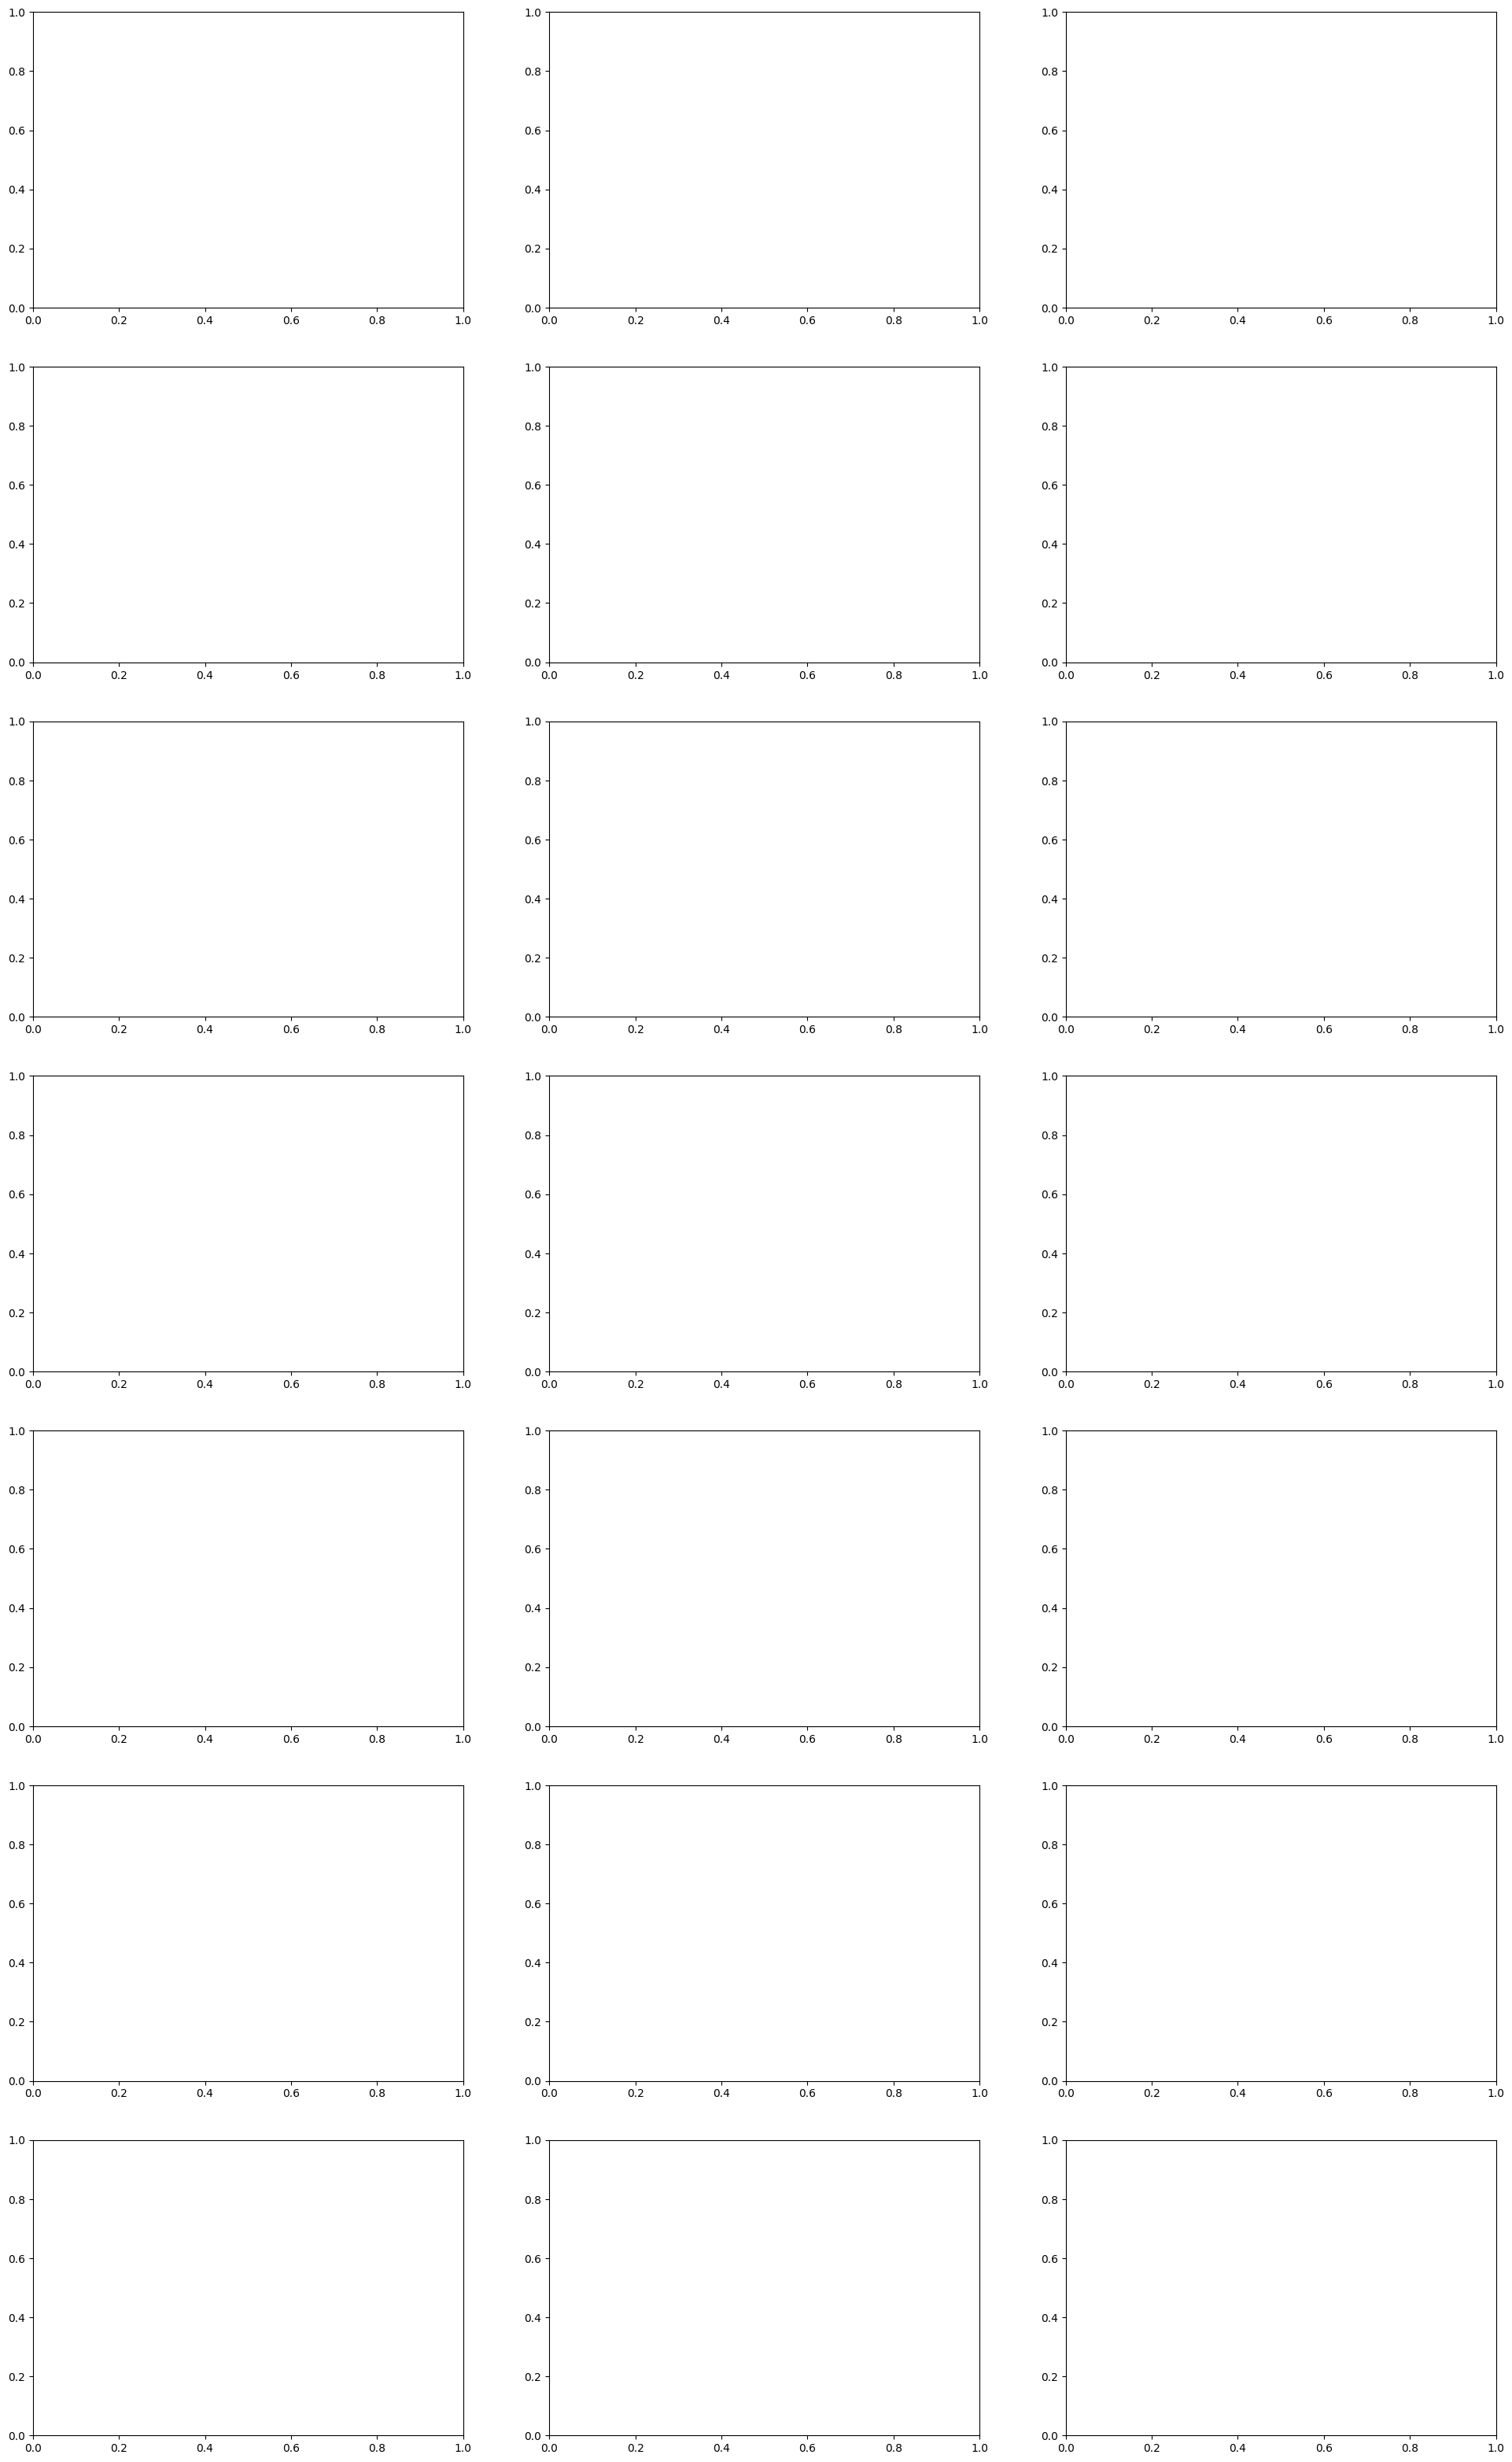

In [6]:
from matplotlib.patches import Rectangle # Rectangle where both axes' 1-sigma regions overlap

model, _ = load_npe("Dingo_sin.pt")


# Test on several different true frequencies, phases, and amplitudes
test_frequencies = [1.0, 2.5, 4.0]
test_phases = [0.5, -0.3, 1.2]
test_amplitudes = [1.0, 0.8, 2.4]

fig, axes = plt.subplots(7, len(test_frequencies), figsize=(8*len(test_frequencies), 40))

print("Testing NPE model on new observations:\n")

for idx, true_freq in enumerate(test_frequencies):
    true_phase = test_phases[idx]
    true_amp = test_amplitudes[idx]
    print(f"\nTest {idx+1}: True Frequency = {true_freq}, True Phase = {true_phase:.2f}, True Amplitude = {true_amp:.2f}")
    
    # Generate new observation
    observed_data = simulate_sine_wave(true_freq, phase=true_phase, amplitude=true_amp)
    
    # Infer posterior
    posterior_samples, stats = infer_NPE(model, observed_data, num_samples=5000)
    
    # Handle both 1D and 2D cases for posterior samples
    if len(posterior_samples.shape) == 1:
        # 1D case - shouldn't happen with 3 params
        amp_samples = posterior_samples
        freq_samples = posterior_samples
        phase_samples = posterior_samples
    else:
        # 2D case [num_samples, 3] with [amplitude, frequency, phase]
        amp_samples = posterior_samples[:, 0]
        freq_samples = posterior_samples[:, 1]
        phase_samples = posterior_samples[:, 2]
    
    freq_stats = {
        'mean': np.mean(freq_samples),
        'median': np.median(freq_samples),
        'std': np.std(freq_samples),
        'q05': np.percentile(freq_samples, 5),
        'q95': np.percentile(freq_samples, 95),
    }
    
    phase_stats = {
        'mean': np.mean(phase_samples),
        'median': np.median(phase_samples),
        'std': np.std(phase_samples),
        'q05': np.percentile(phase_samples, 5),
        'q95': np.percentile(phase_samples, 95),
    }
    
    amp_stats = {
        'mean': np.mean(amp_samples),
        'median': np.median(amp_samples),
        'std': np.std(amp_samples),
        'q05': np.percentile(amp_samples, 5),
        'q95': np.percentile(amp_samples, 95),
    }
    
    parameters = ['amplitude', 'frequency', 'phase']
    ps = ['A', 'f', 'φ']
    samples_list = [amp_samples, freq_samples, phase_samples]
    stats_list = [amp_stats, freq_stats, phase_stats]
    true_list = [true_amp, true_freq, true_phase]

    print(f"  Frequency posterior: mean={freq_stats['mean']:.3f} ± {freq_stats['std']:.3f}")
    print(f"  Phase posterior:     mean={phase_stats['mean']:.3f} ± {phase_stats['std']:.3f}")
    print(f"  Amplitude posterior: mean={amp_stats['mean']:.3f} ± {amp_stats['std']:.3f}")
    
    t = np.linspace(0, 6*np.pi, 1000)

    # Plot observed data
    axes[0, idx].plot(t, observed_data, 'b-', alpha=0.7, linewidth=1.5, label='Observed')
    axes[0, idx].plot(t, true_amp * np.sin(2*np.pi*true_freq * t + true_phase), 'r--', 
                      label=f'True (f={true_freq}, φ={true_phase:.2f}, A={true_amp:.2f})', linewidth=2)
    axes[0, idx].set_title(f'Test {idx+1}: f={true_freq}, φ={true_phase:.2f}, A={true_amp:.2f}', fontsize=12, fontweight='bold')
    axes[0, idx].set_xlabel('Time')
    axes[0, idx].set_ylabel('Value')
    axes[0, idx].legend(fontsize=8)
    axes[0, idx].grid(True, alpha=0.3)

    for idx2, _ in enumerate(parameters):
        axes[idx2 + 1, idx].hist(samples_list[idx2], bins=60, density=True, 
                      alpha=0.6, edgecolor='black', label='Posterior')
        axes[idx2 + 1, idx].axvline(true_list[idx2], color='red', linestyle='--', 
                             linewidth=2.5, label=f'True: {true_list[idx2]:.2f}', zorder=10)
        axes[idx2 + 1, idx].axvline(stats_list[idx2]['mean'], color='green', linestyle='-', 
                             linewidth=2.5, label=f"Mean: {stats_list[idx2]['mean']:.2f}", zorder=10)
        axes[idx2 + 1, idx].axvspan(stats_list[idx2]['q05'], stats_list[idx2]['q95'], alpha=0.2, color='gray', label='90% CI')
        axes[idx2 + 1, idx].set_title(f'p({parameters[idx2]} | data)', fontsize=12, fontweight='bold')
        axes[idx2 + 1, idx].set_xlabel(parameters[idx2].capitalize())
        axes[idx2 + 1, idx].set_ylabel('Density')
        axes[idx2 + 1, idx].legend(loc='upper right', fontsize=8)
        axes[idx2 + 1, idx].grid(True, alpha=0.3)

    for idx2, _ in enumerate(parameters):
        # 2D histograms for parameter pairs
        h = axes[len(parameters) + idx2 + 1, idx].hist2d(samples_list[idx2], samples_list[(idx2+1) % 3], bins=60, cmap='plasma', density=True)
        plt.colorbar(h[3], ax=axes[len(parameters) + idx2 + 1, idx], label='Probability Density')
        axes[len(parameters) + idx2 + 1, idx].scatter(true_list[idx2], true_list[(idx2+1) % 3], color='cyan', s=200, marker='x',  
                            edgecolors='white', linewidth=2, label='True values', zorder=10) # Plot true values
        axes[len(parameters) + idx2 + 1, idx].scatter(stats_list[idx2]['mean'], stats_list[(idx2+1) % 3]['mean'], color='lime', s=100, marker='o', 
                            linewidth=3, label='Posterior mean', zorder=10) # Plot mean

        rect = Rectangle((stats_list[idx2]['mean'] - stats_list[idx2]['std'], stats_list[(idx2+1) % 3]['mean'] - stats_list[(idx2+1) % 3]['std']), 
                        width=2*stats_list[idx2]['std'], height=2*stats_list[(idx2+1) % 3]['std'],
                        facecolor='yellow', edgecolor='yellow', linewidth=2, 
                        alpha=0.3, label='1σ region', zorder=5)
        
        axes[len(parameters) + idx2 + 1, idx].add_patch(rect)
        axes[len(parameters) + idx2 + 1, idx].set_xlabel(parameters[idx2], fontsize=12, fontweight='bold')
        axes[len(parameters) + idx2 + 1, idx].set_ylabel(parameters[(idx2+1) % 3], fontsize=12, fontweight='bold')
        axes[len(parameters) + idx2 + 1, idx].set_title(f'Joint Posterior p({ps[idx2]}, {ps[(idx2+1) % 3]} | data)\nTrue: {ps[idx2]}={true_list[idx2]}, {ps[(idx2+1) % 3]}={true_list[(idx2+1) % 3]}', fontsize=12, fontweight='bold')
        axes[len(parameters) + idx2 + 1, idx].legend(loc='upper right', fontsize=8)
        axes[len(parameters) + idx2 + 1, idx].grid(True, alpha=0.3)

    
plt.tight_layout()
plt.show()